In [1]:
%cd /private/home/pakamienny/Research/symbolicregression
%load_ext autoreload
%autoreload 2


/private/home/pakamienny/Research/symbolicregression


In [2]:
import numpy as np


from symbolicregression.envs.environment import *
from symbolicregression.metrics import *
from symbolicregression.model.embedders import conv_out_len
from symbolicregression.envs import ExpressionGeneratorArgs, ExpressionGenerator
from symbolicregression.envs import Node, NodeParseError
from parsers import default_params as params


In [5]:
from symbolicregression.envs import build_env
from symbolicregression.model import build_modules

env = build_env(params)
env.set_rng(np.random.RandomState(0))

RandomState(MT19937) at 0x7F29F233B140

In [95]:
from parsers import default_params as params
params.global_rank =1
dataloader = create_train_iterator(env, data_path="", params=params)
train_iterator = iter(dataloader)

In [89]:


test_iterator = iter(create_test_iterator(env, "","", params=params))


In [96]:
samples = next(train_iterator)

In [102]:
import pickle
run_dir = Path("/checkpoint/pakamienny/new_symbolicregression/Feb20/tokens_per_batch_10000_lr_0.0002_accumulate_gradients_5_embedder_type_conv_use_emb_positional_embeddings_True/2023-02-20_13-01-43/")
run_dir = Path("/checkpoint/pakamienny/new_symbolicregression/Feb20/tokens_per_batch_10000_lr_0.0002_accumulate_gradients_1_embedder_type_conv_use_emb_positional_embeddings_True/2023-02-21_00-41-46")
#from parsers import default_params as params

params = pickle.load(open(run_dir / "params.pkl", "rb"))
params.reload_model = str(run_dir / "best-r2_train_median_synthetic.pth")

In [104]:
env = build_env(params)
env.set_rng(np.random.RandomState(0))
modules = build_modules(env, params)
embedder, encoder, decoder = (modules["embedder_module"], modules["encoder_module"], modules["decoder_module"])
embedder.eval()
encoder.eval()
decoder.eval()

output_word2id = modules["output_word2id"]
output_id2word = modules["output_id2word"]
output_tokenizer = modules["output_tokenizer"]


In [105]:


def forward_greedy_model(x, y, optimize=False):
    x1, x1_len = embedder([(x[:params.n_max_observations], y[:params.n_max_observations])])
    encoded = encoder("fwd", x=x1, lengths=x1_len, causal=False).transpose(0, 1)
    generations, _ = decoder.generate(encoded, x1_len, sample_temperature=None, max_len=100)
    generations = generations.transpose(0, 1)
    ytildes = []
    for dataset_id, generation in zip(np.arange(len(generations)), generations):
        words = [output_id2word[tok.item()] for tok in generation]
        while words[-1] == "<PAD>": words.pop(-1)
        assert words[0]=="<EOS>" and words[-1]=="<EOS>"
        try:
            decoded_expression: Node = output_tokenizer.decode(words[1:-1])
        except NodeParseError:
            continue
        display(decoded_expression.to_sympy())

        if optimize:
            decoded_expression = run_torch_optim(decoded_expression, x, y, True)
        prefix = decoded_expression.prefix()
        ytilde = decoded_expression.evaluate(x)
        r2_train = stable_r2_score(y, ytilde)
        display(decoded_expression.to_sympy())
        ytildes.append(ytilde)
        print(decoded_expression, r2_train)

    plt.clf()
    plt.scatter(x[:params.n_max_observations], y[:params.n_max_observations], c="g")
    plt.scatter(x[params.n_max_observations:], y[params.n_max_observations:], c="r")

    for ytilde in ytildes:
        plt.scatter(x[:params.n_max_observations], ytilde[:params.n_max_observations], c="g", marker="x")
        plt.scatter(x[params.n_max_observations:], ytilde[params.n_max_observations:], c="r", marker="x")

    plt.show()

In [122]:
expr, (x,y) = env.get_sample(params.n_max_observations+100, 3, 1) 
display(expr.to_sympy())



x_0*sin(x_0) - 1.05065383658749

-0.24/x_0

-0.24/x_0

(-1.2000000000000002/(x_0+(x_0+(x_0+(x_0+x_0))))) -42.918835422366215


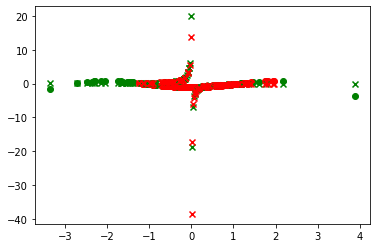

In [123]:
import matplotlib.pyplot as plt

forward_greedy_model(x, y, False)



In [ ]:
forward_greedy_model(x, y, True)

In [93]:
expressions = samples["expression"]
x = samples["x"]
y = samples["y"]
is_train = samples["is_train"]

bs = len(x)
xys = [(xi[mask], yi[mask]) for xi, yi, mask in zip(x, y, is_train)] 
x1, x1_len = embedder(xys)
x2, len2 = batch_expressions(output_tokenizer, output_word2id, expressions)


In [79]:
x1.shape, x1_len

(torch.Size([128, 74, 512]),
 tensor([123, 123, 123, 123, 123, 123, 123, 123, 125, 125, 125, 125, 125, 125,
         125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125,
         125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125,
         125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126,
         126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 128, 128, 128,
         128, 128, 128, 128], device='cuda:0'))

In [74]:
for xi in 

(torch.Size([62, 74]),
 tensor([42, 53, 31, 41, 14, 31, 23, 21, 62, 43, 18, 23, 38, 40,  5, 25, 50, 37,
         51, 42, 21, 60, 17, 54, 23, 39, 37, 14, 22, 26, 54, 19, 21, 18, 57, 45,
         41, 19, 37, 19, 29, 51, 44, 23, 14, 18, 48, 54, 45, 33, 36, 42, 26, 46,
         25, 40, 28, 34, 18, 45, 19, 10, 20, 35, 13, 33, 20, 32, 34, 21, 44, 30,
         46, 24]))

In [70]:
x1.shape

torch.Size([128, 74, 512])

In [ ]:
%%time

encoded = encoder("fwd", x=x1, lengths=x1_len, causal=False).transpose(0, 1)


In [ ]:
%%time

generations, _ = decoder.generate(encoded, x1_len, sample_temperature=None, max_len=50)


In [ ]:
generations

In [ ]:
df = pd.read_csv(run_dir / "eval_in-domain/epoch_25.csv", delimiter=";")#.drop(["Unnamed: 0"])
df["expression"] = df["expression"].apply(lambda x: Node.from_prefix(x))
df[["r2_train", "expression", "ground_truth"]].head(10)

In [ ]:
for expression in df["expression"]:
    print(Node.from_prefix(expression))